# FDW Crop Production Data Profiling - Zimbabwe
- Admin level 3 (Communal (PS)) data is available from 1981-2000. This is aggregated to admin level 2.

In [6]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes, load_shapefile
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [7]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('../data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32736' # Zimbabwe
ZW_Admin2_2007 = load_shapefile('../data/shapefile/fewsnet/ZW_Admin2_2007.shp', epsg)
ZW_Admin2_2009 = load_shapefile('../data/shapefile/fewsnet/ZW_Admin2_2009.shp', epsg)
ZW_Admin2_2011 = load_shapefile('../data/shapefile/fewsnet/ZW_Admin2_2011.shp', epsg)
ZW_Admin2_2018 = load_shapefile('../data/shapefile/fewsnet/ZW_Admin2_2018.shp', epsg)
ZW_Admin3_1981 = load_shapefile('../data/shapefile/fewsnet/ZW_Crop_Regions_1981.shp', epsg)
ZW_Admin3_1993 = load_shapefile('../data/shapefile/fewsnet/ZW_Crop_Regions_1993.shp', epsg)
# There is an issue with the FNID of ZW_Admin2_2011, so we manually correct it
temp = ZW_Admin2_2018[ZW_Admin2_2018['FNID'].isin(['ZW2018A21503', 'ZW2018A21525'])]
temp['FNID'] = ['ZW2011A21503', 'ZW2011A21525']
ZW_Admin2_2011 = pd.concat([ZW_Admin2_2011[~ZW_Admin2_2011['FNID'].isin(temp['FNID'])], temp], axis=0).sort_values('FNID').reset_index(drop=True)
shape_all = pd.concat([ZW_Admin2_2007, ZW_Admin2_2009, ZW_Admin2_2011, ZW_Admin2_2018, ZW_Admin3_1981, ZW_Admin3_1993], axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Zimbabwe',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 2007	 | nan | 0	| ZW2007A2	| 84	| nan	| 0	|
| 2009	 | nan | 0	| ZW2009A2	| 85	| nan	| 0	|
| 2011	 | nan | 0	| ZW2011A2	| 89	| nan	| 0	|
| 2018	 | nan | 0	| ZW2018A2	| 89	| nan	| 0	|
----------------------------------------------- #


<AxesSubplot:xlabel='season_year'>

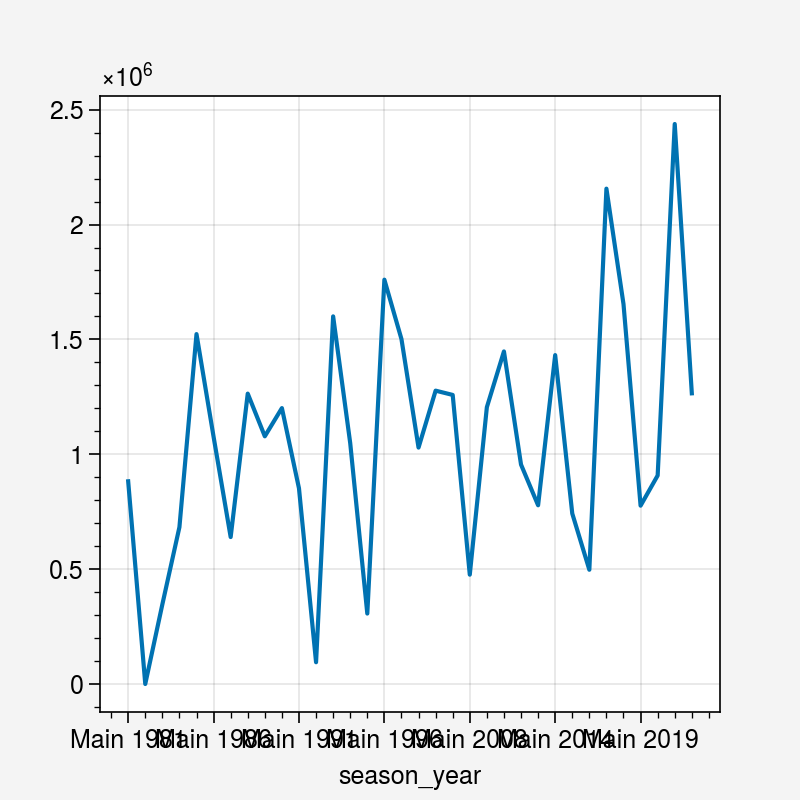

In [8]:
sub = df[
    (df['product'] == 'Maize Grain (White)') &
    (df['indicator'] == 'Quantity Produced')
]
sub.groupby('season_year')['value'].sum().plot()

In [9]:
df['admin_level'] = df['fnid'].apply(lambda x: x[:8])
df.pivot_table(index='season_year', columns='indicator', values='value', aggfunc='count')

indicator,Area Harvested,Area Planted,Quantity Produced,Yield
season_year,,,,
Main 1981,0,425,418,418
Main 1982,0,0,0,0
Main 1983,0,355,312,312
Main 1984,0,365,336,336
Main 1985,0,438,426,426
Main 1986,0,446,406,406
Main 1987,0,438,391,391
Main 1988,0,446,444,444
Main 1989,0,422,400,400


In [10]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([ZW_Admin2_2007, ZW_Admin2_2009, ZW_Admin2_2011, ZW_Admin2_2018], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 56,056
Removed 22,673 "Missing Value" points
0/14,014 "Area Harvested" points are retained.
11,359/14,014 "Area Planted" points are retained.
11,286/14,014 "Quantity Produced" points are retained.
10,738/14,014 "Yield" points are retained.
Current data points: 33,383

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1981 - 2022
7 grain types are found: Maize Grain (White), Millet, Millet (Bulrush), Millet (Finger), Rice (Paddy), Sorghum, Sorghum (Brown)
1 seasons are found: Main (04-01)
2 crop production system are found: Communal (PS), All (PS)
Data sources include:
[1] Ministry of Agriculture, AGRITEX, Zimbabwe --- Agritex field survey reports, Zimbabwe
[2] MoA, Zimbabwe --- Ministry of Agriculture Crop Assessment Report 2nd round, Zimbabwe
[3] MoA, Zimbabwe --- Ministry of Agriculture Crop Assessment Report, Zimbabwe
Administrative-1 fnids: 0
Admin

- Zimbabwe crop seasonal calendar

<img src="../figures/crop_calendar/seasonal-calendar-zimbabwe.png"  width=900><br>

<img src="../figures/crop_calendar/Zimbabwe_-_Crop_calendar.jpg"  width=900>

- Shapefile information

| Year  | Admin-1  | # units  | Admin-2  | # units |
| :---: | :----:   | :----:   | :----:   | :---:   |
| 1981	 | ZW1981A1 | 8	| ZW1981A2	| 58	|
| 2007	 | ZW2007A1 | 10	| ZW2007A2	| 84	|
| 2008	 | ZW2008A1 | 10	| ZW2008A2	| 84	|
| 2009	 | ZW2009A1 | 10	| ZW2009A2	| 85	|
| 2011	 | ZW2011A1 | 10	| ZW2011A2	| 89	|
| 2018	 | ZW2018A1 | 10	| **`ZW2018A2`**	| 89	|

- The number of units for ZW2011A2 and ZW2018A2 are the same, but the boundaries have been changed.

- Comparison between admin boundaries.

<img src="../figures/ZW_admin_shapes.png"  width=900>

- **`ZW2018A2`** is used to represent the current admin-level 2 crop data.
- Zimbabwe has a single crop season: `Main`.
- Zimbabwe has no population group(s).
- Zimbabwe has no crop production system(s).

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = ZW_Admin2_2018.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

ZW2007A21732:	"Gokwe South" (FDW) is changed to "Gokwe South Rural" (shapefile).
ZW2007A21404:	"Kariba Rural" (FDW) is changed to "Kariba" (shapefile).
ZW2009A21304:	"Marondera Rural" (FDW) is changed to "Marondera" (shapefile).
ZW2009A21732:	"Gokwe South" (FDW) is changed to "Gokwe South Rural" (shapefile).
ZW2009A21602:	"Bulilima" (FDW) is changed to "Bulilimamangwe North" (shapefile).
ZW2009A21625:	"Mangwe" (FDW) is changed to "Bulilimamangwe South" (shapefile).
ZW2009A21404:	"Kariba Rural" (FDW) is changed to "Kariba" (shapefile).
ZW2011A21202:	"Muzarabani" (FDW) is changed to "Centenary" (shapefile).
ZW2011A21304:	"Marondera Rural" (FDW) is changed to "Marondera" (shapefile).
ZW2011A21404:	"Kariba Rural" (FDW) is changed to "Kariba" (shapefile).


In [7]:
# Link admin boundaries ------------------------- #
link_2007, over_2007 = FDW_PD_CreateAdminLink(ZW_Admin2_2007, ZW_Admin2_2018, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2009, over_2009 = FDW_PD_CreateAdminLink(ZW_Admin2_2009, ZW_Admin2_2018, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2011, over_2011 = FDW_PD_CreateAdminLink(ZW_Admin2_2011, ZW_Admin2_2018, 'ADMIN2', 'ADMIN2', prod, epsg)

CBR is considered for 'ZW2007A21204' as no record found in: ['ZW2018A21209']
CBR is considered for 'ZW2007A21732' as no record found in: ['ZW2018A21729']
CBR is considered for 'ZW2007A21722' as no record found in: ['ZW2018A21722']
CBR is considered for 'ZW2007A21922' as no record found in: ['ZW2018A21922']
CBR is considered for 'ZW2007A21423' as no record found in: ['ZW2018A21423']
CBR is considered for 'ZW2007A21621' as no record found in: ['ZW2018A21621']
CBR is considered for 'ZW2007A21503' as no record found in: ['ZW2018A21503']
CBR is considered for 'ZW2007A21725' as no record found in: ['ZW2018A21725']
CBR is considered for 'ZW2007A21923' as no record found in: ['ZW2018A21923']
CBR is considered for 'ZW2007A21326' as no record found in: ['ZW2018A21326']
CBR is considered for 'ZW2007A21626' as no record found in: ['ZW2018A21623']
CBR is considered for 'ZW2007A21622' as no record found in: ['ZW2018A21622']
CBR is considered for 'ZW2007A21823' as no record found in: ['ZW2018A21822']